* https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
!pip install category_encoders

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
import sys
sys.path.insert(0,'/drive/My Drive/TP_Datos_2C2021/parte_2/')

In [ ]:
from preprocessing import *

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 70

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

#filtrado de warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
hamburguesas_values, hamburguesas_target, hamburguesas_test = descargar_datasets(
    url_values = 'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs',
    url_target = 'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs', 
    url_test = 'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8'
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    hamburguesas_values, 
    hamburguesas_target, 
    test_size=0.4,
    random_state=66, 
    stratify=hamburguesas_target.astype(str)
)

In [ ]:
X_val_dev, X_test_holdout, y_val_dev, y_test_holdout = train_test_split(
    X_test, 
    y_test, 
    test_size=0.1,
    random_state=66, 
    stratify=y_test.astype(str)
)

In [ ]:
#hamburguesas_values_sn, hamburguesas_val_dev_sn, hamburguesas_test_hold_out_sn = knn_imputer(X_train, X_val_dev, X_test_holdout)
#hamburguesas_val_dev_sn = knn_imputer(X_val_dev)
#hamburguesas_test_sn = knn_imputer(hamburguesas_test)

In [ ]:
#hamburguesas_values_escalado = standar_scaler(hamburguesas_values_sn)
#hamburguesas_val_dev_escalado = standar_scaler(hamburguesas_val_dev_sn)
#hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)

Hay un bug con el feature barrio (el cual se da cuando hacemos `scaled_dataset[categoricos] = dataset[categoricos]`) cuando aplicamos standar_escaler:

In [ ]:
#display(len(hamburguesas_values_sn.barrio.unique()), len(hamburguesas_values_escalado.barrio.unique()), 
#        len(hamburguesas_val_dev_sn.barrio.unique()), len(hamburguesas_val_dev_escalado.barrio.unique()))

In [ ]:
#display(len(hamburguesas_values_sn.barrio.unique()), len(hamburguesas_values_escalado.barrio.unique()))

# Knn imputer, robust scaler, one hot encoding y hashing trick

In [ ]:
hamburguesas_train_values_ht, hamburguesas_val_dev_values_ht, X_test_holdout_sn = preprocessing_knn_imputer_robust_escaler_one_hot_encoding_hashing_trick(
    X_train, 
    X_val_dev, 
    X_test_holdout
)


hamburguesas_train_target_enc = y_train['llovieron_hamburguesas_al_dia_siguiente'].map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev['llovieron_hamburguesas_al_dia_siguiente'].map({'no': 0, 'si': 1, np.NaN: 0})

## Búsqueda de hiperparámetros

In [ ]:
knn_model = KNeighborsClassifier()

leaf_size = [1, 15]
weights = ["uniform", "distance"]
n_neighbors = [40, 55, 65]
p = [1, 2]
metric = ["euclidean", "manhattan", "chebyshev"]

knn_hyperparameters = dict(weights=weights, n_neighbors=n_neighbors, leaf_size=leaf_size, p=p, metric=metric)

In [ ]:
knn_hyperparameters

{'weights': ['uniform', 'distance'],
 'n_neighbors': [40, 55, 65],
 'leaf_size': [1, 15],
 'p': [1, 2],
 'metric': ['euclidean', 'manhattan', 'chebyshev']}

Sacado de XGBoost (de la sección que se llama igual que la presente):

In [ ]:
columnas_a_usar = ['humedad_tarde',
                   'rafaga_viento_max_velocidad',
                   'nubosidad_tarde',
                   'mm_lluvia_dia',
                   'presion_atmosferica_tarde',
                   'horas_de_sol',
                   'mes',
                   'presion_atmosferica_temprano',
                   'direccion_viento_temprano_Sursureste']

In [ ]:
df_reducido = hamburguesas_train_values_ht[columnas_a_usar]

In [ ]:
gsearch = GridSearchCV(estimator=knn_model, param_grid=knn_hyperparameters, cv=5, verbose=4, scoring='roc_auc')
gsearch.fit(df_reducido, hamburguesas_train_target_enc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.844 total time=   5.8s
[CV 2/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.843 total time=   5.6s
[CV 3/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.845 total time=   6.3s
[CV 4/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.846 total time=   6.3s
[CV 5/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.850 total time=   6.0s
[CV 1/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.845 total time=   6.9s
[CV 2/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.844 total time=   7.0s
[CV 3/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.846 total time=   6.9s
[CV 4/5] END leaf_size=

[CV 3/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.846 total time=   9.9s
[CV 4/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.849 total time=  10.5s
[CV 5/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.853 total time=  10.2s
[CV 1/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.847 total time=  10.7s
[CV 2/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.846 total time=  10.1s
[CV 3/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.848 total time=   9.2s
[CV 4/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.850 total time=   9.2s
[CV 5/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.854 total time=   9.2s
[CV 1/5] END leaf_size=1, metric=manhattan, n_neighbors=55, p=1, weights=uniform;, 

[CV 5/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=uniform;, score=0.845 total time=   2.4s
[CV 1/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.843 total time=   2.3s
[CV 2/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.843 total time=   2.3s
[CV 3/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.844 total time=   2.2s
[CV 4/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.845 total time=   2.3s
[CV 5/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.847 total time=   2.3s
[CV 1/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, score=0.842 total time=   2.3s
[CV 2/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, score=0.842 total time=   2.3s
[CV 3/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, 

[CV 2/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.845 total time=   2.5s
[CV 3/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.849 total time=   2.6s
[CV 4/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.850 total time=   2.5s
[CV 5/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.852 total time=   2.5s
[CV 1/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.848 total time=   2.7s
[CV 2/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.844 total time=   2.7s
[CV 3/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.848 total time=   2.7s
[CV 4/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.850 total time=   3.0s
[CV 5/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=un

[CV 3/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.850 total time=   5.1s
[CV 4/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.852 total time=   5.3s
[CV 5/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.855 total time=   5.9s
[CV 1/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.849 total time=   5.9s
[CV 2/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.846 total time=   6.0s
[CV 3/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.849 total time=   5.8s
[CV 4/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.851 total time=   8.3s
[CV 5/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.853 total time=   6.0s
[CV 1/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=dis

[CV 4/5] END leaf_size=15, metric=chebyshev, n_neighbors=65, p=2, weights=distance;, score=0.846 total time=   1.8s
[CV 5/5] END leaf_size=15, metric=chebyshev, n_neighbors=65, p=2, weights=distance;, score=0.847 total time=   2.0s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 15],
                         'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [40, 55, 65], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=4)

In [ ]:
parametros = gsearch.best_params_
parametros

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 65,
 'p': 1,
 'weights': 'distance'}

In [ ]:
gsearch.best_score_

0.8507680497561267

* n_neighbors = 65
* weights = distance
* leaf_size = 1
* p = 1
* metric = manhattan,

Como ya encontramos los mejores hiperparámetros, creamos un diccionario con dichos valores (esto es para cuando no podamos hacer el `.best_params_` porque no ejecutamos GridSearch cuando usamos el notebook otro día debido al tiempo que insume)

In [ ]:
parametros = {'leaf_size': 1,
              'metric': 'manhattan',
              'n_neighbors': 65,
              'p': 1,
              'weights': 'distance'}

## Entrenamos y vemos cómo nos va

Vemos qué pasa si separamos así nomas al `df_reducido` en 5. Para eso vemos las proporciones:

In [ ]:
modelo = KNeighborsClassifier(**parametros)
modelo.fit(df_reducido, hamburguesas_train_target_enc)

KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=65, p=1,
                     weights='distance')

In [ ]:
prediccion = modelo.predict_proba(hamburguesas_val_dev_values_ht[columnas_a_usar])[:,1]

In [ ]:
roc_auc_score(hamburguesas_val_dev_target_enc, prediccion, average='micro')

0.8540002597630827

In [ ]:
prediccion = modelo.predict(hamburguesas_val_dev_values_ht[columnas_a_usar])

In [ ]:
accuracy_score(hamburguesas_val_dev_target_enc, prediccion)

0.8398061728689757

In [ ]:
recall_score(hamburguesas_val_dev_target_enc, prediccion)

0.44427464250627663

In [ ]:
precision_score(hamburguesas_val_dev_target_enc, prediccion)

0.7152899824253075

In [ ]:
f1_score(hamburguesas_val_dev_target_enc, prediccion)

0.5481112383004512

In [ ]:
cm = confusion_matrix(hamburguesas_val_dev_target_enc, prediccion)

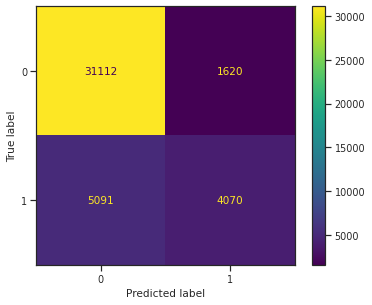

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot()
plt.show()

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos, arriba a la izquierda), $fp$ (falsos positivos, abajo a la izquierda), $tn$ (verdaderos negativos, abajo a la derecha) y $fn$ (falsos negativos, arriba a la derecha) en una matriz.

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36203 casos, 86,42%) que negativos (5690 casos, 13,58%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

## Predicciones

In [ ]:
hamburguesas_test_ohe = preprocessing_knn_imputer_robust_escaler_one_hot_encoding_hashing_trick(
    None,
    None,
    None,
    hamburguesas_test,

hamburguesas_test_ohe_reducido = hamburguesas_test_ohe[columnas_a_usar]

In [ ]:
predicciones = modelo.predict(hamburguesas_test_ohe_reducido)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

In [ ]:
nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

In [ ]:
for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

In [ ]:
nuestra_prediccion.to_csv('KNN_knn_imputer_robust_escaler_one_hot_encoding_hashing_trick.csv')

In [ ]:
nuestra_prediccion.to_csv('/drive/My Drive/TP_Datos_2C2021/parte_2/KNN_hashing_trick.csv')

# Mean imputer, standar scaler, one hot encoding y binary encoding

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_mean_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

hamburguesas_train_target_enc = y_train['llovieron_hamburguesas_al_dia_siguiente'].map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev['llovieron_hamburguesas_al_dia_siguiente'].map({'no': 0, 'si': 1, np.NaN: 0})

## Búsqueda de hiperparámetros

In [ ]:
knn_model = KNeighborsClassifier()

leaf_size = [1, 15]
weights = ["uniform", "distance"]
n_neighbors = [40, 55, 65]
p = [1, 2]
metric = ["euclidean", "manhattan", "chebyshev"]

knn_hyperparameters = dict(weights=weights, n_neighbors=n_neighbors, leaf_size=leaf_size, p=p, metric=metric)

In [ ]:
knn_hyperparameters

{'weights': ['uniform', 'distance'],
 'n_neighbors': [40, 55, 65],
 'leaf_size': [1, 15],
 'p': [1, 2],
 'metric': ['euclidean', 'manhattan', 'chebyshev']}

Sacado de XGBoost (de la sección que se llama igual que la presente)

In [ ]:
columnas_a_usar = ['humedad_tarde',
                   'rafaga_viento_max_velocidad',
                   'horas_de_sol',
                   'nubosidad_tarde',
                   'mm_lluvia_dia',
                   'presion_atmosferica_temprano',
                   'mes',
                   'presion_atmosferica_tarde',
                   'rafaga_viento_max_direccion_Noreste']

In [ ]:
df_reducido = hamburguesas_train_values_bin[columnas_a_usar]

In [ ]:
gsearch = GridSearchCV(estimator=knn_model, param_grid=knn_hyperparameters, cv=5, verbose=4, scoring='roc_auc')
gsearch.fit(df_reducido, hamburguesas_train_target_enc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.848 total time=   6.5s
[CV 2/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.848 total time=   6.5s
[CV 3/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.846 total time=   6.4s
[CV 4/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.846 total time=   6.3s
[CV 5/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=uniform;, score=0.850 total time=   6.6s
[CV 1/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.844 total time=   6.4s
[CV 2/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.841 total time=   6.5s
[CV 3/5] END leaf_size=1, metric=euclidean, n_neighbors=40, p=1, weights=distance;, score=0.841 total time=   6.8s
[CV 4/5] END leaf_size=

[CV 3/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.847 total time=  10.2s
[CV 4/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.846 total time=   9.7s
[CV 5/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=uniform;, score=0.852 total time=   9.4s
[CV 1/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.845 total time=   9.6s
[CV 2/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.840 total time=   9.5s
[CV 3/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.842 total time=   9.5s
[CV 4/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.840 total time=   9.6s
[CV 5/5] END leaf_size=1, metric=manhattan, n_neighbors=40, p=2, weights=distance;, score=0.849 total time=   8.7s
[CV 1/5] END leaf_size=1, metric=manhattan, n_neighbors=55, p=1, weights=uniform;, 

[CV 5/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=uniform;, score=0.851 total time=   3.2s
[CV 1/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.847 total time=   3.9s
[CV 2/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.842 total time=   4.6s
[CV 3/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.841 total time=   3.4s
[CV 4/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.842 total time=   3.4s
[CV 5/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=1, weights=distance;, score=0.848 total time=   3.3s
[CV 1/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, score=0.850 total time=   3.6s
[CV 2/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, score=0.848 total time=   3.2s
[CV 3/5] END leaf_size=1, metric=chebyshev, n_neighbors=55, p=2, weights=uniform;, 

[CV 2/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.843 total time=   3.5s
[CV 3/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.844 total time=   3.5s
[CV 4/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.842 total time=   3.5s
[CV 5/5] END leaf_size=15, metric=euclidean, n_neighbors=55, p=2, weights=distance;, score=0.849 total time=   3.4s
[CV 1/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.852 total time=   4.2s
[CV 2/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.851 total time=   4.4s
[CV 3/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.850 total time=   4.2s
[CV 4/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=uniform;, score=0.850 total time=   4.4s
[CV 5/5] END leaf_size=15, metric=euclidean, n_neighbors=65, p=1, weights=un

[CV 3/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.845 total time=   5.6s
[CV 4/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.844 total time=   5.6s
[CV 5/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=1, weights=distance;, score=0.850 total time=   5.5s
[CV 1/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.853 total time=   5.6s
[CV 2/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.852 total time=   5.5s
[CV 3/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.850 total time=   5.6s
[CV 4/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.851 total time=   5.6s
[CV 5/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=uniform;, score=0.853 total time=   5.5s
[CV 1/5] END leaf_size=15, metric=manhattan, n_neighbors=65, p=2, weights=dis

[CV 4/5] END leaf_size=15, metric=chebyshev, n_neighbors=65, p=2, weights=distance;, score=0.842 total time=   2.6s
[CV 5/5] END leaf_size=15, metric=chebyshev, n_neighbors=65, p=2, weights=distance;, score=0.849 total time=   2.5s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 15],
                         'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [40, 55, 65], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=4)

In [ ]:
parametros = gsearch.best_params_
parametros

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 65,
 'p': 1,
 'weights': 'uniform'}

In [ ]:
parametros = {'leaf_size': 1,
              'metric': 'manhattan',
              'n_neighbors': 65,
              'p': 1,
              'weights': 'uniform'}

In [ ]:
gsearch.best_score_

0.8516840818747774

* n_neighbors = 65
* weights = uniform
* leaf_size = 1
* p = 1
* metric = manhattan

Como ya encontramos los mejores hiperparámetros, creamos un diccionario con dichos valores (esto es para cuando no podamos hacer el `.best_params_` porque no ejecutamos GridSearch cuando usamos el notebook otro día debido al tiempo que insume)

## Entrenamos y vemos cómo nos va

In [ ]:
modelo = KNeighborsClassifier(**parametros)
modelo.fit(df_reducido, hamburguesas_train_target_enc)

KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=65, p=1)

In [ ]:
prediccion = modelo.predict_proba(hamburguesas_val_dev_values_bin[columnas_a_usar])[:,1]

In [ ]:
roc_auc_score(hamburguesas_val_dev_target_enc, prediccion)

0.85474906289931

In [ ]:
prediccion = modelo.predict(hamburguesas_val_dev_values_bin[columnas_a_usar])

In [ ]:
accuracy_score(hamburguesas_val_dev_target_enc, prediccion)

0.8423364285202779

In [ ]:
recall_score(hamburguesas_val_dev_target_enc, prediccion)

0.4340137539569916

In [ ]:
precision_score(hamburguesas_val_dev_target_enc, prediccion)

0.7368421052631579

In [ ]:
f1_score(hamburguesas_val_dev_target_enc, prediccion)

In [ ]:
cm = confusion_matrix(hamburguesas_val_dev_target_enc, prediccion)

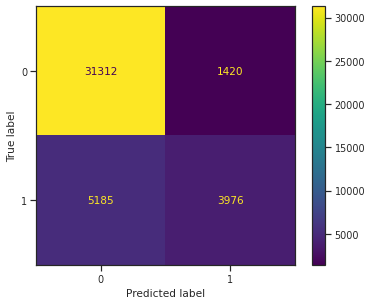

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot()
plt.show()

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (36497 casos, 87,12%) que negativos (5396 casos, 12,88%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

## Predicciones

Dado que en todos los folds se obtuvo mejor score del auc con Binary encoding que en Hashing trick; el ganador para hacer la predicción es el modelo de esta sección (el mejor modelo de su mismo tipo).

In [ ]:
hamburguesas_test_ohe = preprocessing_mean_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    None,
    None,
    None,
    hamburguesas_test,
    True)

hamburguesas_test_ohe_reducido = hamburguesas_test_ohe[columnas_a_usar]

In [ ]:
predicciones = modelo.predict(hamburguesas_test_ohe_reducido)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

In [ ]:
nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

In [ ]:
for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

In [ ]:
nuestra_prediccion.to_csv('KNN_mean_imputer_standar_escaler_one_hot_encoding_binary_encoding.csv')

In [ ]:
nuestra_prediccion.to_csv('/drive/My Drive/TP_Datos_2C2021/parte_2/KNN_binary_encoding.csv')